## Showing the signal in a medical way


The first data loading method and the [ecg_plot](https://github.com/dy1901/ecg_plot) library have been used in this section. 

This library allows to create a plot more similar to the medical field, with all the available signal channels.

The necessary libraries are imported and a random number generator is created.

In [5]:
import pandas as pd
import numpy as np
import ast
import wfdb
from wfdb import processing
import matplotlib.pyplot as plt
import heartpy as hp
import ecg_plot
import os
import glob

import warnings
warnings.filterwarnings('ignore')

# Create random generator with its seed
rng = np.random.default_rng(123)

Functions for loading data. Their operation is described in the functions.

In [6]:
def load_raw_data(df:pd.core.frame.DataFrame, sampling_rate:int, path:str):
    """Load data from DataFrame acording to sampling rate

    Args:
        df (pandas.core.frame.DataFrame): DataFrame to read
        sampling_rate (int): Sampling rate of signal
        path (str): Path that contains signal data

    Returns:
        numpy.ndarray: Signal data
    """

    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    
    data = np.array([signal for signal, meta in data])
    return data

def aggregate_diagnostic(y_dic:dict):
    """Add diagnostics from csv 

    Args:
        y_dic (dict): Contains diagnostic 

    Returns:
        list: Diagnostic in list format
    """
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

The data are loaded following the [documentation](https://physionet.org/content/ptb-xl/1.0.2/) scheme. It can be seen that the data is ready to be used in an artificial intelligence training system.

In [9]:
# Setup data variables
path = 'data/physionet.org/files/ptb-xl/1.0.2/'
sampling_rate = 100 # Sampling rate of the signal (100 or 500)

# Check that the folder exists
try:
    folder_exists = os.path.exists(path)
    if not folder_exists: 
        raise FileNotFoundError()
except FileNotFoundError:
    print("Folder " + path + " does not exists!")

# Load and convert annotation data
Y_aux = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y_aux.scp_codes = Y_aux.scp_codes.apply(lambda x: ast.literal_eval(x))

# Subset of one random data
Y = Y_aux.sample()

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

It is necessary to transpose the data so that the library accepts it correctly. 

By default, the library loads the 12 leads differently from the [database documentation](https://physionet.org/content/ptb-xl/1.0.2/), so this needs to be corrected.

Finally, the graph is showed and saved.

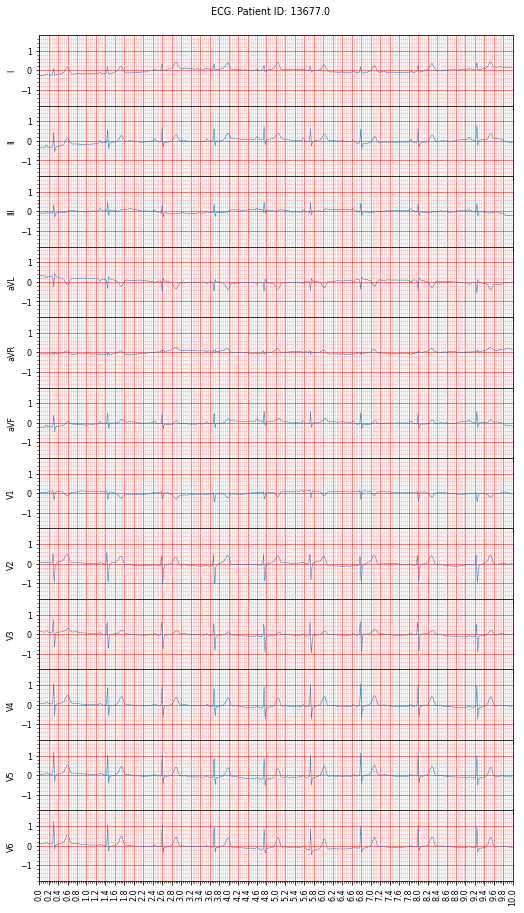

In [11]:
X_swap = np.transpose(X, (0, 2, 1)) # Swap shape to use in library ecg_plot
lead_index = ['I', 'II', 'III', 'aVL', 'aVR', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'] # Correct order

ecg_plot.plot_12(X_swap[0,:,:], 
                 sample_rate = sampling_rate, 
                 title = 'ECG || Patient ID: ' + str(Y["patient_id"].values[0]), 
                 lead_index=lead_index, 
                 columns=1) # Plot signals

ecg_plot.show()

ecg_plot.save_as_png("medic_ecg", dpi=600) # Save image as png